## POS tagging using modified Viterbi

### Problem Statement:
- Vanilla Viterbi algorithm has a comparitively lower accuracy.
- This is due to algorithm assigning arbitrary tags when unknown words are encountered in test dataset.
- Since the emission probailities of these candidates are '0', algorithm arbitrarily chooses the first tag.
- To address this, it is expected to build two modified Viterbi algorithms which will address the unknown words and tag them correctly.

### Goals:
- Which tags are assigned to unknown words? Use the patterns in unknown words to develop rules to tag unknown words.
- Solve the problem of unknown Viterbi using at least two techniques.
- Compare the tagging accuracy after making these modifications with the vanilla Viterbi algorithm.
- List down at least three cases from the sample test file (i.e. unknown word-tag pairs) which were incorrectly tagged by the original Viterbi POS tagger and got corrected after your modifications.



### Step 1: Data Preparation

In [44]:
#Importing libraries
import nltk, re, pprint
import numpy as np
import pandas as pd
import requests
import matplotlib.pyplot as plt
import seaborn as sns
import pprint, time
import random
from sklearn.model_selection import train_test_split
from nltk.tokenize import word_tokenize

In [45]:
# reading the Treebank tagged sentences
nltk_data = list(nltk.corpus.treebank.tagged_sents(tagset='universal'))

In [46]:
print(nltk_data[:40])

[[('Pierre', 'NOUN'), ('Vinken', 'NOUN'), (',', '.'), ('61', 'NUM'), ('years', 'NOUN'), ('old', 'ADJ'), (',', '.'), ('will', 'VERB'), ('join', 'VERB'), ('the', 'DET'), ('board', 'NOUN'), ('as', 'ADP'), ('a', 'DET'), ('nonexecutive', 'ADJ'), ('director', 'NOUN'), ('Nov.', 'NOUN'), ('29', 'NUM'), ('.', '.')], [('Mr.', 'NOUN'), ('Vinken', 'NOUN'), ('is', 'VERB'), ('chairman', 'NOUN'), ('of', 'ADP'), ('Elsevier', 'NOUN'), ('N.V.', 'NOUN'), (',', '.'), ('the', 'DET'), ('Dutch', 'NOUN'), ('publishing', 'VERB'), ('group', 'NOUN'), ('.', '.')], [('Rudolph', 'NOUN'), ('Agnew', 'NOUN'), (',', '.'), ('55', 'NUM'), ('years', 'NOUN'), ('old', 'ADJ'), ('and', 'CONJ'), ('former', 'ADJ'), ('chairman', 'NOUN'), ('of', 'ADP'), ('Consolidated', 'NOUN'), ('Gold', 'NOUN'), ('Fields', 'NOUN'), ('PLC', 'NOUN'), (',', '.'), ('was', 'VERB'), ('named', 'VERB'), ('*-1', 'X'), ('a', 'DET'), ('nonexecutive', 'ADJ'), ('director', 'NOUN'), ('of', 'ADP'), ('this', 'DET'), ('British', 'ADJ'), ('industrial', 'ADJ'), ('

In [47]:
# Splitting into train and test
random.seed(1234)
train_set, test_set = train_test_split(nltk_data,train_size=0.95,test_size=0.05, random_state=42)

print(len(train_set))
print(len(test_set))
print(train_set[:40])

3718
196
[[('Bank', 'NOUN'), ('of', 'ADP'), ('New', 'NOUN'), ('England', 'NOUN'), ("'s", 'PRT'), ('shares', 'NOUN'), ('are', 'VERB'), ('traded', 'VERB'), ('*-1', 'X'), ('on', 'ADP'), ('the', 'DET'), ('New', 'NOUN'), ('York', 'NOUN'), ('Stock', 'NOUN'), ('Exchange', 'NOUN'), ('.', '.')], [('$', '.'), ('130', 'NUM'), ('million', 'NUM'), ('*U*', 'X'), ('of', 'ADP'), ('general', 'ADJ'), ('obligation', 'NOUN'), ('distributable', 'ADJ'), ('state', 'NOUN'), ('aid', 'NOUN'), ('bonds', 'NOUN'), ('due', 'ADJ'), ('1991-2000', 'NUM'), ('and', 'CONJ'), ('2009', 'NUM'), (',', '.'), ('tentatively', 'ADV'), ('priced', 'VERB'), ('*', 'X'), ('by', 'ADP'), ('a', 'DET'), ('Chemical', 'NOUN'), ('Securities', 'NOUN'), ('Inc.', 'NOUN'), ('group', 'NOUN'), ('*', 'X'), ('to', 'PRT'), ('yield', 'VERB'), ('from', 'ADP'), ('6.20', 'NUM'), ('%', 'NOUN'), ('in', 'ADP'), ('1991', 'NUM'), ('to', 'PRT'), ('7.272', 'NUM'), ('%', 'NOUN'), ('in', 'ADP'), ('2009', 'NUM'), ('.', '.')], [('``', '.'), ('They', 'PRON'), ('wer

In [48]:
# Getting list of tagged words
train_tagged_words = [tup for sent in train_set for tup in sent]
len(train_tagged_words)

95589

In [49]:
# tokens 
tokens = [pair[0] for pair in train_tagged_words]
tokens[:10]

['Bank', 'of', 'New', 'England', "'s", 'shares', 'are', 'traded', '*-1', 'on']

In [50]:
# vocabulary
V = set(tokens)
print(len(V))

12109


In [51]:
# number of tags
T = set([pair[1] for pair in train_tagged_words])
len(T)

12

In [52]:
print(T)

{'DET', 'ADV', 'NOUN', 'X', 'NUM', 'ADJ', 'ADP', 'PRT', 'VERB', 'PRON', 'CONJ', '.'}


### Step 2. POS Tagging Algorithm - Vanilla Viterbi

We'll use the HMM algorithm to tag the words. Given a sequence of words to be tagged, the task is to assign the most probable tag to the word. 

In other words, to every word w, assign the tag t that maximises the likelihood P(t/w). Since P(t/w) = P(w/t). P(t) / P(w), after ignoring P(w), we have to compute P(w/t) and P(t).


P(w/t) is basically the probability that given a tag (say NN), what is the probability of it being w (say 'building'). This can be computed by computing the fraction of all NNs which are equal to w, i.e. 

P(w/t) = count(w, t) / count(t). 


The term P(t) is the probability of tag t, and in a tagging task, we assume that a tag will depend only on the previous tag. In other words, the probability of a tag being NN will depend only on the previous tag t(n-1). So for e.g. if t(n-1) is a JJ, then t(n) is likely to be an NN since adjectives often precede a noun (blue coat, tall building etc.).


Given the penn treebank tagged dataset, we can compute the two terms P(w/t) and P(t) and store them in two large matrices. The matrix of P(w/t) will be sparse, since each word will not be seen with most tags ever, and those terms will thus be zero. 


#### Emission Probabilities

In [53]:
# computing P(w/t) and storing in T x V matrix
t = len(T) #Tag
v = len(V) #Word/Vocabulary
w_given_t = np.zeros((t, v))

In [54]:
print(t)
print(v)
w_given_t

12
12109


array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [55]:
# compute word given tag: Emission Probability
def word_given_tag(word, tag, train_bag = train_tagged_words):
    tag_list = [pair for pair in train_bag if pair[1]==tag]
    count_tag = len(tag_list)
    w_given_tag_list = [pair[0] for pair in tag_list if pair[0]==word]
    count_w_given_tag = len(w_given_tag_list)
    
    return (count_w_given_tag, count_tag)

In [56]:
# examples

# large
print("\n", "large")
print(word_given_tag('large', 'ADJ'))
print(word_given_tag('large', 'VERB'))
print(word_given_tag('large', 'NOUN'), "\n")

# will
print("\n", "will")
print(word_given_tag('will', 'ADP'))
print(word_given_tag('will', 'NOUN'))
print(word_given_tag('will', 'VERB'))

# book
print("\n", "book")
print(word_given_tag('book', 'NOUN'))
print(word_given_tag('book', 'VERB'))


 large
(27, 6077)
(0, 12885)
(0, 27423) 


 will
(0, 9345)
(1, 27423)
(268, 12885)

 book
(7, 27423)
(1, 12885)


#### Transition Probabilities

In [57]:
# compute tag given tag: tag2(t2) given tag1 (t1), i.e. Transition Probability

def t2_given_t1(t2, t1, train_bag = train_tagged_words):
    tags = [pair[1] for pair in train_bag]
    count_t1 = len([t for t in tags if t==t1])
    count_t2_t1 = 0
    for index in range(len(tags)-1):
        if tags[index]==t1 and tags[index+1] == t2:
            count_t2_t1 += 1
    return (count_t2_t1, count_t1)

In [58]:
# examples
print(t2_given_t1(t2='NOUN', t1='ADJ'))
print(t2_given_t1('DET', 'X'))
print(t2_given_t1('NOUN', 'DET'))
print(t2_given_t1('NOUN', 'VERB'))
print(t2_given_t1('NOUN', 'NOUN'))
print(t2_given_t1('PRON', 'PRON'))
print(t2_given_t1('VERB', 'ADV'))

(4234, 6077)
(346, 6276)
(5302, 8284)
(1429, 12885)
(7257, 27423)
(21, 2618)
(1037, 3010)


In [59]:
#Please note P(tag|start) is same as P(tag|'.')
print(t2_given_t1('DET', '.'))
print(t2_given_t1('VERB', '.'))
print(t2_given_t1('NOUN', '.'))
print(t2_given_t1('PRON', '.'))


(1929, 11118)
(984, 11118)
(2481, 11118)
(727, 11118)


In [60]:
t

12

In [61]:
# creating t x t transition matrix of tags
# each column is t2, each row is t1
# thus M(i, j) represents P(tj given ti)

tags_matrix = np.zeros((len(T), len(T)), dtype='float32')
for i, t1 in enumerate(list(T)):
    for j, t2 in enumerate(list(T)): 
        tags_matrix[i, j] = t2_given_t1(t2, t1)[0]/t2_given_t1(t2, t1)[1]
tags_matrix

array([[5.31144394e-03, 1.23128919e-02, 6.40028954e-01, 4.55094166e-02,
        2.19700634e-02, 2.04973444e-01, 9.05359723e-03, 2.41429268e-04,
        3.83872539e-02, 3.74215352e-03, 4.82858537e-04, 1.79864801e-02],
       [6.71096370e-02, 8.10631216e-02, 3.08970101e-02, 2.35880390e-02,
        3.05647831e-02, 1.30232558e-01, 1.19601332e-01, 1.36212623e-02,
        3.44518274e-01, 1.56146176e-02, 6.31229253e-03, 1.36877075e-01],
       [1.33099956e-02, 1.68836378e-02, 2.64631867e-01, 2.91361269e-02,
        9.62695573e-03, 1.22889541e-02, 1.76275387e-01, 4.38318215e-02,
        1.47977978e-01, 4.92287474e-03, 4.19356003e-02, 2.39178792e-01],
       [5.51306568e-02, 2.51752716e-02, 6.13448061e-02, 7.64818341e-02,
        2.70873168e-03, 1.65710635e-02, 1.42925426e-01, 1.85787126e-01,
        2.03632891e-01, 5.60866781e-02, 1.03569152e-02, 1.63798600e-01],
       [3.27088917e-03, 2.97353556e-03, 3.55337501e-01, 2.06660718e-01,
        1.84061855e-01, 3.41956578e-02, 3.47903669e-02, 2.79

In [62]:
# convert the matrix to a df for better readability
tags_df = pd.DataFrame(tags_matrix, columns = list(T), index=list(T))
tags_df

,DET,ADV,NOUN,X,NUM,ADJ,ADP,PRT,VERB,PRON,CONJ,.
DET,0.005311,0.012313,0.640029,0.045509,0.021970,0.204973,0.009054,0.000241,0.038387,0.003742,0.000483,0.017986
ADV,0.067110,0.081063,0.030897,0.023588,0.030565,0.130233,0.119601,0.013621,0.344518,0.015615,0.006312,0.136877
NOUN,0.013310,0.016884,0.264632,0.029136,0.009627,0.012289,0.176275,0.043832,0.147978,0.004923,0.041936,0.239179
X,0.055131,0.025175,0.061345,0.076482,0.002709,0.016571,0.142925,0.185787,0.203633,0.056087,0.010357,0.163799
NUM,0.003271,0.002974,0.355338,0.206661,0.184062,0.034196,0.034790,0.027951,0.017544,0.001487,0.013381,0.118347
ADJ,0.005101,0.004608,0.696725,0.021392,0.020405,0.066645,0.078986,0.010861,0.012342,0.000658,0.016949,0.065328
ADP,0.326378,0.013162,0.321776,0.034029,0.062921,0.105297,0.017228,0.001498,0.008240,0.069128,0.000856,0.039486
PRT,0.100360,0.010134,0.242563,0.013403,0.058516,0.086303,0.021576,0.001635,0.402746,0.018960,0.002288,0.041517
VERB,0.133101,0.082577,0.110904,0.218005,0.022817,0.064649,0.090493,0.031121,0.169189,0.036244,0.005588,0.035312
PRON,0.009549,0.033995,0.211230,0.092819,0.007257,0.074866,0.022918,0.012223,0.480901,0.008021,0.004966,0.041253


In [63]:
tags_df.loc['.', :] #Probability of all other tags given previous tag was'.' i.e. start of sentence

DET     0.173502
ADV     0.052078
NOUN    0.223152
X       0.026623
NUM     0.080500
ADJ     0.044972
ADP     0.091114
PRT     0.002339
VERB    0.088505
PRON    0.065389
CONJ    0.057924
.       0.093812
Name: ., dtype: float32

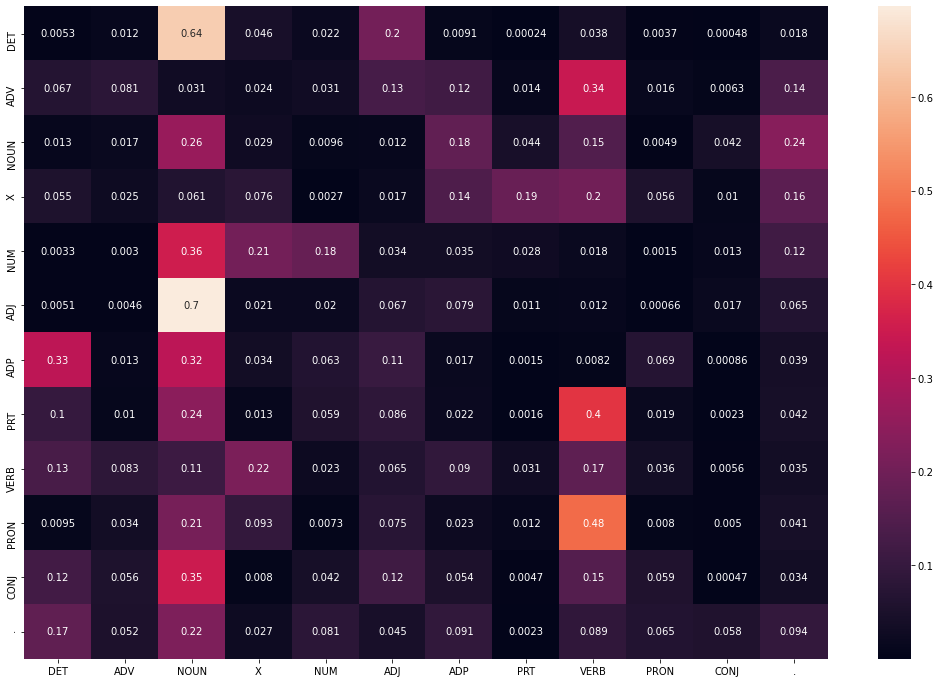

In [64]:
# heatmap of tags matrix
# T(i, j) means P(tag j given tag i)
plt.figure(figsize=(18, 12))
sns.heatmap(tags_df,annot=True)
plt.show()


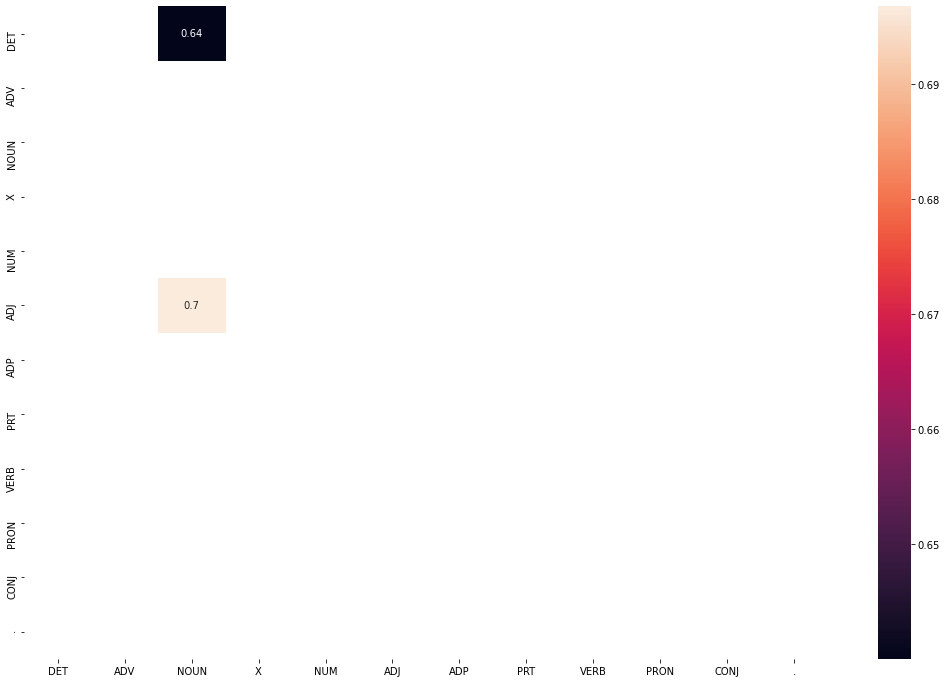

In [65]:
# frequent tags
# filter the df to get P(t2, t1) > 0.5
tags_frequent = tags_df[tags_df>0.5]
plt.figure(figsize=(18, 12))
sns.heatmap(tags_frequent,annot=True)
plt.show()

### Step 3: Build the vanilla Viterbi based POS tagger
Let's now use the computed probabilities P(w, tag) and P(t2, t1) to assign tags to each word in the document. We'll run through each word w and compute P(tag/w)=P(w/tag).P(tag) for each tag in the tag set, and then assign the tag having the max P(tag/w).

We'll store the assigned tags in a list of tuples, similar to the list 'train_tagged_words'. Each tuple will be a (token, assigned_tag). As we progress further in the list, each tag to be assigned will use the tag of the previous token.

Note: P(tag|start) = P(tag|'.') 

In [66]:
len(train_tagged_words)

95589

In [67]:
# Viterbi Heuristic
def Viterbi(words, train_bag = train_tagged_words):
    state = []
    T = list(set([pair[1] for pair in train_bag])) #set of all tags
    
    for key, word in enumerate(words): #key represents index
        #initialise list of probability column for a given observation
        p = [] 
        for tag in T:
            if key == 0: #If key=[], then consider this as start of sentence, previous tag ='.'
                transition_p = tags_df.loc['.', tag]
            else:
                transition_p = tags_df.loc[state[-1], tag]
                
            # compute emission and state probabilities
            emission_p = word_given_tag(words[key], tag)[0]/word_given_tag(words[key], tag)[1]
            state_probability = emission_p * transition_p    
            p.append(state_probability)
            
        pmax = max(p)
        # getting state for which probability is maximum
        state_max = T[p.index(pmax)] 
        state.append(state_max)
    return list(zip(words, state))



### Step 3.1: Evaluating on Test Set

In [68]:
# list of tagged words
test_run_base = [tup for sent in test_set for tup in sent]

# list of untagged words
test_tagged_words = [tup[0] for sent in test_set for tup in sent]
print("Test run:\n", test_set)
TTest = set([tup[1] for sent in test_set for tup in sent])
print("\n")
print("Tags in test: \n", TTest)

Test run:
 [[('For', 'ADP'), ('the', 'DET'), ('Agency', 'NOUN'), ('for', 'ADP'), ('International', 'NOUN'), ('Development', 'NOUN'), (',', '.'), ('appropriators', 'NOUN'), ('approved', 'VERB'), ('$', '.'), ('200', 'NUM'), ('million', 'NUM'), ('*U*', 'X'), ('in', 'ADP'), ('secondary', 'ADJ'), ('loan', 'NOUN'), ('guarantees', 'NOUN'), ('under', 'ADP'), ('an', 'DET'), ('expanded', 'VERB'), ('trade', 'NOUN'), ('credit', 'NOUN'), ('insurance', 'NOUN'), ('program', 'NOUN'), (',', '.'), ('and', 'CONJ'), ('total', 'ADJ'), ('loan', 'NOUN'), ('guarantees', 'NOUN'), ('for', 'ADP'), ('the', 'DET'), ('Overseas', 'NOUN'), ('Private', 'NOUN'), ('Investment', 'NOUN'), ('Corp.', 'NOUN'), ('are', 'VERB'), ('increased', 'VERB'), ('*-3', 'X'), ('by', 'ADP'), ('$', '.'), ('40', 'NUM'), ('million', 'NUM'), ('*U*', 'X'), ('over', 'ADP'), ('fiscal', 'ADJ'), ('1989', 'NUM'), ('as', 'ADP'), ('part', 'NOUN'), ('of', 'ADP'), ('the', 'DET'), ('same', 'ADJ'), ('Poland', 'NOUN'), ('package', 'NOUN'), ('.', '.')], [(

In [69]:
len(test_set)

196

In [70]:
# tagging the test sentences
start = time.time()
taggedSeqVanilla = Viterbi(test_tagged_words)
end = time.time()
difference = end-start
print(difference)

1083.4407894611359


In [71]:
print("Time taken in seconds: ", difference)
print(taggedSeqVanilla)

Time taken in seconds:  1083.4407894611359
[('For', 'ADP'), ('the', 'DET'), ('Agency', 'NOUN'), ('for', 'ADP'), ('International', 'NOUN'), ('Development', 'NOUN'), (',', '.'), ('appropriators', 'NOUN'), ('approved', 'VERB'), ('$', '.'), ('200', 'NUM'), ('million', 'NUM'), ('*U*', 'X'), ('in', 'ADP'), ('secondary', 'ADJ'), ('loan', 'NOUN'), ('guarantees', 'NOUN'), ('under', 'ADP'), ('an', 'DET'), ('expanded', 'VERB'), ('trade', 'VERB'), ('credit', 'NOUN'), ('insurance', 'NOUN'), ('program', 'NOUN'), (',', '.'), ('and', 'CONJ'), ('total', 'ADJ'), ('loan', 'NOUN'), ('guarantees', 'NOUN'), ('for', 'ADP'), ('the', 'DET'), ('Overseas', 'DET'), ('Private', 'ADJ'), ('Investment', 'NOUN'), ('Corp.', 'NOUN'), ('are', 'VERB'), ('increased', 'VERB'), ('*-3', 'X'), ('by', 'ADP'), ('$', '.'), ('40', 'NUM'), ('million', 'NUM'), ('*U*', 'X'), ('over', 'ADP'), ('fiscal', 'ADJ'), ('1989', 'NUM'), ('as', 'ADP'), ('part', 'NOUN'), ('of', 'ADP'), ('the', 'DET'), ('same', 'ADJ'), ('Poland', 'NOUN'), ('packa

In [72]:
# accuracy
check = [i for i, j in zip(taggedSeqVanilla, test_run_base) if i == j] 

In [73]:
accuracy = len(check)/len(taggedSeqVanilla)
accuracy

0.9138981718104974

In [74]:
incorrect_tagged_cases = [[test_run_base[i-1],j] for i, j in enumerate(zip(taggedSeqVanilla, test_run_base)) if j[0]!=j[1]]
incorrect_tagged_cases

[[('expanded', 'VERB'), (('trade', 'VERB'), ('trade', 'NOUN'))],
 [('the', 'DET'), (('Overseas', 'DET'), ('Overseas', 'NOUN'))],
 [('Overseas', 'NOUN'), (('Private', 'ADJ'), ('Private', 'NOUN'))],
 [('settled', 'VERB'), (('pre-1917', 'DET'), ('pre-1917', 'ADJ'))],
 [('``', '.'), (('Unemployment', 'DET'), ('Unemployment', 'NOUN'))],
 [('the', 'DET'), (('purchasing', 'NOUN'), ('purchasing', 'VERB'))],
 [('weekly', 'ADJ'), (('paycheck', 'DET'), ('paycheck', 'NOUN'))],
 [('paycheck', 'NOUN'), (('reasonably', 'DET'), ('reasonably', 'ADV'))],
 [(',', '.'), (('though', 'ADP'), ('though', 'ADV'))],
 [('such', 'ADJ'), (('close', 'NOUN'), ('close', 'ADJ'))],
 [('acquiring', 'VERB'), (('more', 'ADV'), ('more', 'ADJ'))],
 [('*-1', 'X'), (('Funded', 'DET'), ('Funded', 'VERB'))],
 [('from', 'ADP'), (('Tokio', 'DET'), ('Tokio', 'NOUN'))],
 [('medical', 'ADJ'), (('protocols', 'DET'), ('protocols', 'NOUN'))],
 [('on', 'ADP'), (('preventative', 'DET'), ('preventative', 'ADJ'))],
 [('it', 'PRON'), (('exi

In [75]:
len(incorrect_tagged_cases)/len(taggedSeqVanilla)

0.08610182818950265

### Step 3.2: Solve the problem of unknown words

In [76]:
# Unknown words 

test_vocabulary_set = set([t for t in test_tagged_words])

unknown_words = list(test_vocabulary_set - set(tokens))
print("Total Unknown words :", len(unknown_words))
print("\n")
print("Unknown Words :\n", unknown_words)

Total Unknown words : 299


Unknown Words :
 ['Wilfred', 'alternatively', 'Rhone', 'Northampton', 'science', 'accidents', 'slate', 'acted', 'A.C.', 'floral', 'apologizing', '1.19', 'stock-price', '87.5', 'shop', 'Citizens', '1955', 'replacement-car', '7.422', '20.5', 'avid', 'platinum', 'depend', 'copied', 'Wertheim', '2163.2', 'seconds', 'blames', 'side-crash', 'Peninsula', '17.4', 'exists', 'pasta', '24.95', 'existed', '43.875', 'inheritor', 'auditor', 'fancy', 'longtime', '13.625', 'Communication', 'Legend', 'sue', 'entertaining', 'Schroder', 'Overseas', 'mesothelioma', 'noticed', 'sometimes-exhausting', '405', 'Mogavero', 'bothered', 'pre-existing', 'anti-drug', 'supportive', '16.5', 'schoolchildren', 'frustrating', 'lobbies', 'renewing', 'indulging', 'Iran-Contra', 'wheel-loader', 'shopped', 'spurring', 'concerned', 'protocols', '*T*-222', 'manmade-fiber', 'computer-generated', '1,200', 'Breeden', 'compilation', 'derivatives', 'mandates', 'verge', 'shareholder-rights', 'DiLoreto',

In [77]:
start = time.time()
taggedSeqVanillaUnknown = Viterbi(unknown_words)
end = time.time()
difference = end-start

print("Time taken in seconds: ", difference)


Time taken in seconds:  62.800573110580444


In [78]:
taggedSeqVanillaUnknown


[('Wilfred', 'DET'),
 ('alternatively', 'DET'),
 ('Rhone', 'DET'),
 ('Northampton', 'DET'),
 ('science', 'DET'),
 ('accidents', 'DET'),
 ('slate', 'DET'),
 ('acted', 'DET'),
 ('A.C.', 'DET'),
 ('floral', 'DET'),
 ('apologizing', 'DET'),
 ('1.19', 'DET'),
 ('stock-price', 'DET'),
 ('87.5', 'DET'),
 ('shop', 'DET'),
 ('Citizens', 'DET'),
 ('1955', 'DET'),
 ('replacement-car', 'DET'),
 ('7.422', 'DET'),
 ('20.5', 'DET'),
 ('avid', 'DET'),
 ('platinum', 'DET'),
 ('depend', 'DET'),
 ('copied', 'DET'),
 ('Wertheim', 'DET'),
 ('2163.2', 'DET'),
 ('seconds', 'DET'),
 ('blames', 'DET'),
 ('side-crash', 'DET'),
 ('Peninsula', 'DET'),
 ('17.4', 'DET'),
 ('exists', 'DET'),
 ('pasta', 'DET'),
 ('24.95', 'DET'),
 ('existed', 'DET'),
 ('43.875', 'DET'),
 ('inheritor', 'DET'),
 ('auditor', 'DET'),
 ('fancy', 'DET'),
 ('longtime', 'DET'),
 ('13.625', 'DET'),
 ('Communication', 'DET'),
 ('Legend', 'DET'),
 ('sue', 'DET'),
 ('entertaining', 'DET'),
 ('Schroder', 'DET'),
 ('Overseas', 'DET'),
 ('mesotheli

299 unknown words have been identified from the test set. All these have been tagged as 'PRT'. It is now required to identify the tags for these correctly. 
Note: The tag is randomly assigned and can be different in different run.

This needs to be done through the modifications in the Viterbi algorithm.

Some of the rules that can be observed from the words above are as follows:
- words ending with 'ed' : Typically such words are verbs in the past tense e.g. outdistanced, annoyed, blighted
- words ending with 'ing' : Typically such words are verbs also called gerunds e.g. relating, abating
- Further marking words ending with 'ould' and 'es' as verbs as well e.g. could, would, should or uses, peruses, misuses, derives
- words ending with 'ly' : Typically such words are adverbs e.g.miraculously, robustly
- words ending with 's' : Typically such words are plural nouns e.g.journalists, indications, outsiders
- words ending with 'able' : Typically such words are adjectives e.g.undesirable 
- Further marking words ending with 'ous, 'ful' also as adjectives e.g. joyous, outrageous, beautiful, wonderful 
- Finally, nouns are the most common parts of speech. Hence, using noun as a catch-all in case of any words which get missed out by other rules<br>

This can be done using **rule-based models**.



### Method 1: Viterbi Modification - A unigram tagger backed off by a rule based tagger


Lexicon (Unigram) Tagger

In [79]:
# Lexicon (or unigram tagger)
unigram_tagger = nltk.UnigramTagger(train_set)
unigram_tagger.evaluate(test_set)

0.911735797129939

Using Rule -Based Models for POS tagging

In [80]:
# specify patterns for tagging
# as observed from unknown samples as well as general understanding of english usage
patterns = [
    (r'.*ing$', 'VERB'),              # gerund
    (r'.*ed$', 'VERB'),               # past tense
    (r'.*es$', 'VERB'),               # 3rd singular present
    (r'.*ould$', 'VERB'),              # modals
    (r'.*\'s$', 'PRON$'),              # possessive nouns
    (r'.*s$', 'NOUN'),                # plural nouns
    (r'^-?[0-9]+(.[0-9]+)?$', 'NUM'), # cardinal numbers
    (r'.*able$', 'ADJ'),              # Adjective
    (r'.*ous$', 'ADJ'),
    (r'.*ful$', 'ADJ'),                #common Adjective suffixes
    (r'.*ly$', 'ADV'),                 #Adverb - Common adverb suffix
    (r'.*', 'NOUN')                    # nouns
]

In [81]:
regexp_tagger = nltk.RegexpTagger(patterns)

In [82]:
regexp_tagger.evaluate(test_set)

0.3444073127580106

Combining taggers

In [83]:
# rule based tagger
rule_based_tagger = nltk.RegexpTagger(patterns)

# lexicon backed up by the rule-based tagger
lexicon_tagger = nltk.UnigramTagger(train_set, backoff=rule_based_tagger)

lexicon_tagger.evaluate(test_set)

0.9528209160605465

Defining a lexicon tagger with unigram tagger backed off by regex based tagger

In [84]:
def lexiconTagger(word,train_set = train_set):
    patterns1 = [
    (r'.*ing$', 'VERB'),              # gerund
    (r'.*ed$', 'VERB'),               # past tense
    (r'.*es$', 'VERB'),               # 3rd singular present
    (r'.*ould$', 'VERB'),              # modals
    (r'.*\'s$', 'PRON$'),              # possessive nouns
    (r'.*s$', 'NOUN'),                # plural nouns
    (r'^-?[0-9]+(.[0-9]+)?$', 'NUM'), # cardinal numbers
    (r'.*able$', 'ADJ'),              # Adjective
    (r'.*ous$', 'ADJ'),
    (r'.*ful$', 'ADJ'),                #common Adjective suffixes
    (r'.*ly$', 'ADV'),                 #Adverb - Common adverb suffix
    (r'.*', 'NOUN')                    # nouns
]
    regexBasedTagger = nltk.RegexpTagger(patterns1)

    # trigram backed up by the regex tagger
    unigramRegexTagger = nltk.UnigramTagger(train_set, backoff=regexBasedTagger)
    return unigramRegexTagger.tag_sents([[(word)]])

In [85]:
# Viterbi with modifications from lexicon tagger
def ViterbiLexMod(words, train_bag = train_tagged_words):
    state = []
    T = list(set([pair[1] for pair in train_bag])) #set of all tags
    
    for key, word in enumerate(words): #key represents index
        #unknown words from lexicon tagger backoff regex tagger
        if word not in tokens:
            unknownWordTag = lexiconTagger(word)
            for sent in unknownWordTag:
                for tup in sent:
                    state.append(tup[1])
        
        #initialise list of probability column for a given observation
        else:
            p = [] 
            for tag in T:
                if key == 0: #If key=[], then consider this as start of sentence, previous tag ='.'
                    transition_p = tags_df.loc['.', tag]
                else:
                    transition_p = tags_df.loc[state[-1], tag]

                # compute emission and state probabilities
                emission_p = word_given_tag(words[key], tag)[0]/word_given_tag(words[key], tag)[1]
                state_probability = emission_p * transition_p    
                p.append(state_probability)

            pmax = max(p)
            # getting state for which probability is maximum
            state_max = T[p.index(pmax)] 
            state.append(state_max)
    return list(zip(words, state))


In [86]:
# tagging the test sentences
start = time.time()
taggedSeqLexicon = ViterbiLexMod(test_tagged_words)
end = time.time()
difference = end-start
print(difference)

1458.8477170467377


#### Evaluating tagging accuracy

In [87]:
# tagging the test sentences
print("Time taken in seconds: ", difference)
print(taggedSeqLexicon)

Time taken in seconds:  1458.8477170467377
[('For', 'ADP'), ('the', 'DET'), ('Agency', 'NOUN'), ('for', 'ADP'), ('International', 'NOUN'), ('Development', 'NOUN'), (',', '.'), ('appropriators', 'NOUN'), ('approved', 'VERB'), ('$', '.'), ('200', 'NUM'), ('million', 'NUM'), ('*U*', 'X'), ('in', 'ADP'), ('secondary', 'ADJ'), ('loan', 'NOUN'), ('guarantees', 'NOUN'), ('under', 'ADP'), ('an', 'DET'), ('expanded', 'VERB'), ('trade', 'VERB'), ('credit', 'NOUN'), ('insurance', 'NOUN'), ('program', 'NOUN'), (',', '.'), ('and', 'CONJ'), ('total', 'ADJ'), ('loan', 'NOUN'), ('guarantees', 'NOUN'), ('for', 'ADP'), ('the', 'DET'), ('Overseas', 'NOUN'), ('Private', 'ADJ'), ('Investment', 'NOUN'), ('Corp.', 'NOUN'), ('are', 'VERB'), ('increased', 'VERB'), ('*-3', 'X'), ('by', 'ADP'), ('$', '.'), ('40', 'NUM'), ('million', 'NUM'), ('*U*', 'X'), ('over', 'ADP'), ('fiscal', 'ADJ'), ('1989', 'NUM'), ('as', 'ADP'), ('part', 'NOUN'), ('of', 'ADP'), ('the', 'DET'), ('same', 'ADJ'), ('Poland', 'NOUN'), ('pack

In [88]:
# accuracy
check1 = [i for i, j in zip(taggedSeqLexicon, test_run_base) if i == j]
accuracy_ViterbiLexMod = len(check1)/len(taggedSeqLexicon)
accuracy_ViterbiLexMod

0.9543935521918616

In [89]:
incorrect_tagged_cases = [[test_run_base[i-1],j] for i, j in enumerate(zip(taggedSeqLexicon, test_run_base)) if j[0]!=j[1]]
incorrect_tagged_cases

[[('expanded', 'VERB'), (('trade', 'VERB'), ('trade', 'NOUN'))],
 [('Overseas', 'NOUN'), (('Private', 'ADJ'), ('Private', 'NOUN'))],
 [('settled', 'VERB'), (('pre-1917', 'NOUN'), ('pre-1917', 'ADJ'))],
 [('the', 'DET'), (('purchasing', 'NOUN'), ('purchasing', 'VERB'))],
 [(',', '.'), (('though', 'ADP'), ('though', 'ADV'))],
 [('such', 'ADJ'), (('close', 'NOUN'), ('close', 'ADJ'))],
 [('acquiring', 'VERB'), (('more', 'ADV'), ('more', 'ADJ'))],
 [('on', 'ADP'), (('preventative', 'NOUN'), ('preventative', 'ADJ'))],
 [(',', '.'), (('so', 'ADV'), ('so', 'ADP'))],
 [('*ICH*-2', 'X'), (('exists', 'NOUN'), ('exists', 'VERB'))],
 [('a', 'DET'), (('middle', 'NOUN'), ('middle', 'ADJ'))],
 [('.', '.'), (('Though', 'NOUN'), ('Though', 'ADP'))],
 [('chalk', 'NOUN'), (('first', 'ADJ'), ('first', 'ADV'))],
 [('on', 'ADP'), (('cross-border', 'NOUN'), ('cross-border', 'ADJ'))],
 [('of', 'ADP'), (('emigres', 'VERB'), ('emigres', 'NOUN'))],
 [('which', 'DET'), (('*T*-133', 'NOUN'), ('*T*-133', 'X'))],
 [(

In [90]:
# checking for inaccuracy ratio
len(incorrect_tagged_cases)/len(taggedSeqLexicon)

0.04560644780813839

### Compare the tagging accuracies of the modifications with the vanilla Viterbi algorithm

In [91]:
start = time.time()
taggedSeqLexiconUnknown = ViterbiLexMod(unknown_words)
end = time.time()
difference = end-start

print("Time taken in seconds: ", difference)


Time taken in seconds:  464.10734248161316


In [92]:
print(taggedSeqLexiconUnknown)

[('Wilfred', 'VERB'), ('alternatively', 'ADV'), ('Rhone', 'NOUN'), ('Northampton', 'NOUN'), ('science', 'NOUN'), ('accidents', 'NOUN'), ('slate', 'NOUN'), ('acted', 'VERB'), ('A.C.', 'NOUN'), ('floral', 'NOUN'), ('apologizing', 'VERB'), ('1.19', 'NUM'), ('stock-price', 'NOUN'), ('87.5', 'NUM'), ('shop', 'NOUN'), ('Citizens', 'NOUN'), ('1955', 'NUM'), ('replacement-car', 'NOUN'), ('7.422', 'NUM'), ('20.5', 'NUM'), ('avid', 'NOUN'), ('platinum', 'NOUN'), ('depend', 'NOUN'), ('copied', 'VERB'), ('Wertheim', 'NOUN'), ('2163.2', 'NUM'), ('seconds', 'NOUN'), ('blames', 'VERB'), ('side-crash', 'NOUN'), ('Peninsula', 'NOUN'), ('17.4', 'NUM'), ('exists', 'NOUN'), ('pasta', 'NOUN'), ('24.95', 'NUM'), ('existed', 'VERB'), ('43.875', 'NUM'), ('inheritor', 'NOUN'), ('auditor', 'NOUN'), ('fancy', 'NOUN'), ('longtime', 'NOUN'), ('13.625', 'NUM'), ('Communication', 'NOUN'), ('Legend', 'NOUN'), ('sue', 'NOUN'), ('entertaining', 'VERB'), ('Schroder', 'NOUN'), ('Overseas', 'NOUN'), ('mesothelioma', 'NOUN

As can be observed, the unknown words have now been tagged. Though it cannot be said whether the tags are correct or not.

### Method 2: Viterbi Modification - Using transition probability only when emission probability is zero 
- Unknown words won't have a set emission probability. 
- The formula we use is state_probability = emission_p * transition_p
- When word is unknown, the state_probability will come to 0 since emission probability is 0.
- Instead, setting the state_probability = transition_p if emission probability is 0 in such a scenario.

In [93]:
# Viterbi with modifications for unknown words
def ViterbiZeroEmission(words, train_bag = train_tagged_words):
    state = []
    T = list(set([pair[1] for pair in train_bag]))
    
    for key, word in enumerate(words):
        #initialise list of probability column for a given observation
        p = [] 
        pTrans =[] # list for storing transition probabilities
        for tag in T:
            if key == 0:
                transP = tags_df.loc['.', tag]
            else:
                transP = tags_df.loc[state[-1], tag]
                
            # compute emission and state probabilities
            emission_p = word_given_tag(words[key], tag)[0]/word_given_tag(words[key], tag)[1]
            state_probability = emission_p * transP    
            p.append(state_probability)
            pTrans.append(transP)
            
        pmax = max(p)
        state_max = T[p.index(pmax)] 
        
      
        # if probability is zero (unknown word) then use transition probability
        if(pmax==0):
            pmax = max(pTrans)
            state_max = T[pTrans.index(pmax)]
                           
        else:
            state_max = T[p.index(pmax)] 
        
        state.append(state_max)
    return list(zip(words, state))

In [94]:
# tagging the test sentences
start = time.time()
taggedSeqZeroEmission = ViterbiZeroEmission(test_tagged_words)
end = time.time()
difference = end-start
print(difference)

1090.373545408249


#### Evaluating tagging accuracy

In [95]:
# tagging the test sentences
print("Time taken in seconds: ", difference)
print(taggedSeqZeroEmission)

Time taken in seconds:  1090.373545408249
[('For', 'ADP'), ('the', 'DET'), ('Agency', 'NOUN'), ('for', 'ADP'), ('International', 'NOUN'), ('Development', 'NOUN'), (',', '.'), ('appropriators', 'NOUN'), ('approved', 'VERB'), ('$', '.'), ('200', 'NUM'), ('million', 'NUM'), ('*U*', 'X'), ('in', 'ADP'), ('secondary', 'ADJ'), ('loan', 'NOUN'), ('guarantees', 'NOUN'), ('under', 'ADP'), ('an', 'DET'), ('expanded', 'VERB'), ('trade', 'VERB'), ('credit', 'NOUN'), ('insurance', 'NOUN'), ('program', 'NOUN'), (',', '.'), ('and', 'CONJ'), ('total', 'ADJ'), ('loan', 'NOUN'), ('guarantees', 'NOUN'), ('for', 'ADP'), ('the', 'DET'), ('Overseas', 'NOUN'), ('Private', 'ADJ'), ('Investment', 'NOUN'), ('Corp.', 'NOUN'), ('are', 'VERB'), ('increased', 'VERB'), ('*-3', 'X'), ('by', 'ADP'), ('$', '.'), ('40', 'NUM'), ('million', 'NUM'), ('*U*', 'X'), ('over', 'ADP'), ('fiscal', 'ADJ'), ('1989', 'NUM'), ('as', 'ADP'), ('part', 'NOUN'), ('of', 'ADP'), ('the', 'DET'), ('same', 'ADJ'), ('Poland', 'NOUN'), ('packa

In [96]:
# accuracy
check1 = [i for i, j in zip(taggedSeqZeroEmission, test_run_base) if i == j]
accuracy_ViterbiZeroEmission = len(check1)/len(taggedSeqZeroEmission)
print(accuracy_ViterbiZeroEmission)

0.9388637703951248


In [97]:
incorrect_tagged_cases = [[test_run_base[i-1],j] for i, j in enumerate(zip(taggedSeqZeroEmission, test_run_base)) if j[0]!=j[1]]
incorrect_tagged_cases

[[('expanded', 'VERB'), (('trade', 'VERB'), ('trade', 'NOUN'))],
 [('Overseas', 'NOUN'), (('Private', 'ADJ'), ('Private', 'NOUN'))],
 [('settled', 'VERB'), (('pre-1917', 'X'), ('pre-1917', 'ADJ'))],
 [('the', 'DET'), (('purchasing', 'NOUN'), ('purchasing', 'VERB'))],
 [('paycheck', 'NOUN'), (('reasonably', 'NOUN'), ('reasonably', 'ADV'))],
 [(',', '.'), (('though', 'ADP'), ('though', 'ADV'))],
 [('such', 'ADJ'), (('close', 'NOUN'), ('close', 'ADJ'))],
 [('acquiring', 'VERB'), (('more', 'ADV'), ('more', 'ADJ'))],
 [('from', 'ADP'), (('Tokio', 'DET'), ('Tokio', 'NOUN'))],
 [('on', 'ADP'), (('preventative', 'DET'), ('preventative', 'ADJ'))],
 [('$', '.'), (('20.5', 'NOUN'), ('20.5', 'NUM'))],
 [('become', 'VERB'), (('polarized', 'X'), ('polarized', 'VERB'))],
 [(',', '.'), (('so', 'ADV'), ('so', 'ADP'))],
 [('a', 'DET'), (('middle', 'NOUN'), ('middle', 'ADJ'))],
 [('.', '.'), (('Though', 'NOUN'), ('Though', 'ADP'))],
 [('totaled', 'VERB'), (('154.2', 'X'), ('154.2', 'NUM'))],
 [('Since', 

In [98]:
len(incorrect_tagged_cases)/len(taggedSeqZeroEmission)

0.06113622960487517

### Compare the tagging accuracies of the modifications with the vanilla Viterbi algorithm

In [99]:
start = time.time()
taggedSeqZeroEmissionUnknown = ViterbiZeroEmission(unknown_words)
end = time.time()
difference = end-start

print("Time taken in seconds: ", difference)


Time taken in seconds:  62.1644287109375


In [100]:
print(taggedSeqZeroEmissionUnknown)

[('Wilfred', 'NOUN'), ('alternatively', 'NOUN'), ('Rhone', 'NOUN'), ('Northampton', 'NOUN'), ('science', 'NOUN'), ('accidents', 'NOUN'), ('slate', 'NOUN'), ('acted', 'NOUN'), ('A.C.', 'NOUN'), ('floral', 'NOUN'), ('apologizing', 'NOUN'), ('1.19', 'NOUN'), ('stock-price', 'NOUN'), ('87.5', 'NOUN'), ('shop', 'NOUN'), ('Citizens', 'NOUN'), ('1955', 'NOUN'), ('replacement-car', 'NOUN'), ('7.422', 'NOUN'), ('20.5', 'NOUN'), ('avid', 'NOUN'), ('platinum', 'NOUN'), ('depend', 'NOUN'), ('copied', 'NOUN'), ('Wertheim', 'NOUN'), ('2163.2', 'NOUN'), ('seconds', 'NOUN'), ('blames', 'NOUN'), ('side-crash', 'NOUN'), ('Peninsula', 'NOUN'), ('17.4', 'NOUN'), ('exists', 'NOUN'), ('pasta', 'NOUN'), ('24.95', 'NOUN'), ('existed', 'NOUN'), ('43.875', 'NOUN'), ('inheritor', 'NOUN'), ('auditor', 'NOUN'), ('fancy', 'NOUN'), ('longtime', 'NOUN'), ('13.625', 'NOUN'), ('Communication', 'NOUN'), ('Legend', 'NOUN'), ('sue', 'NOUN'), ('entertaining', 'NOUN'), ('Schroder', 'NOUN'), ('Overseas', 'NOUN'), ('mesotheli

As can be observed, the unknown words have now been tagged. Though it cannot be said whether the tags are correct or not.

### List down cases which were incorrectly tagged by original POS tagger and got corrected by your modifications

In [101]:
diffTags = [[test_run_base[i-1],j] for i, j in enumerate(zip(test_run_base, taggedSeqVanilla, taggedSeqLexicon, taggedSeqZeroEmission)) 
            if ((j[0]!=j[1]) | (j[0]!=j[2]) | (j[0]!=j[3]) | (j[1]!=j[2]) | (j[1]!=j[3]) | (j[2]!=j[3]))]
diffTags

[[('expanded', 'VERB'),
  (('trade', 'NOUN'),
   ('trade', 'VERB'),
   ('trade', 'VERB'),
   ('trade', 'VERB'))],
 [('the', 'DET'),
  (('Overseas', 'NOUN'),
   ('Overseas', 'DET'),
   ('Overseas', 'NOUN'),
   ('Overseas', 'NOUN'))],
 [('Overseas', 'NOUN'),
  (('Private', 'NOUN'),
   ('Private', 'ADJ'),
   ('Private', 'ADJ'),
   ('Private', 'ADJ'))],
 [('settled', 'VERB'),
  (('pre-1917', 'ADJ'),
   ('pre-1917', 'DET'),
   ('pre-1917', 'NOUN'),
   ('pre-1917', 'X'))],
 [('``', '.'),
  (('Unemployment', 'NOUN'),
   ('Unemployment', 'DET'),
   ('Unemployment', 'NOUN'),
   ('Unemployment', 'NOUN'))],
 [('the', 'DET'),
  (('purchasing', 'VERB'),
   ('purchasing', 'NOUN'),
   ('purchasing', 'NOUN'),
   ('purchasing', 'NOUN'))],
 [('weekly', 'ADJ'),
  (('paycheck', 'NOUN'),
   ('paycheck', 'DET'),
   ('paycheck', 'NOUN'),
   ('paycheck', 'NOUN'))],
 [('paycheck', 'NOUN'),
  (('reasonably', 'ADV'),
   ('reasonably', 'DET'),
   ('reasonably', 'ADV'),
   ('reasonably', 'NOUN'))],
 [(',', '.'),
 

As can be seen above, the modifications have helped resolve some of the incorrect words though not all of them. 

Let's find out the exact words which were corrected by the two modifications.

In [102]:
correctedTags = [[test_run_base[i-1],j] for i, j in enumerate(zip(test_run_base, taggedSeqVanilla, taggedSeqLexicon, taggedSeqZeroEmission)) 
            if ((j[0]==j[2]) & (j[0]==j[3]) & ((j[0]!=j[1]) | (j[1]!=j[2]) | (j[1]!=j[3]) | (j[2]!=j[3])))]
correctedTags

[[('the', 'DET'),
  (('Overseas', 'NOUN'),
   ('Overseas', 'DET'),
   ('Overseas', 'NOUN'),
   ('Overseas', 'NOUN'))],
 [('``', '.'),
  (('Unemployment', 'NOUN'),
   ('Unemployment', 'DET'),
   ('Unemployment', 'NOUN'),
   ('Unemployment', 'NOUN'))],
 [('weekly', 'ADJ'),
  (('paycheck', 'NOUN'),
   ('paycheck', 'DET'),
   ('paycheck', 'NOUN'),
   ('paycheck', 'NOUN'))],
 [('*-1', 'X'),
  (('Funded', 'VERB'),
   ('Funded', 'DET'),
   ('Funded', 'VERB'),
   ('Funded', 'VERB'))],
 [('medical', 'ADJ'),
  (('protocols', 'NOUN'),
   ('protocols', 'DET'),
   ('protocols', 'NOUN'),
   ('protocols', 'NOUN'))],
 [('it', 'PRON'),
  (('existed', 'VERB'),
   ('existed', 'DET'),
   ('existed', 'VERB'),
   ('existed', 'VERB'))],
 [('prospective', 'ADJ'),
  (('acquirers', 'NOUN'),
   ('acquirers', 'DET'),
   ('acquirers', 'NOUN'),
   ('acquirers', 'NOUN'))],
 [("n't", 'ADV'),
  (('noticed', 'VERB'),
   ('noticed', 'DET'),
   ('noticed', 'VERB'),
   ('noticed', 'VERB'))],
 [('touched', 'VERB'),
  (('sl

Looking at above output, we can determine a few examples where the POS tags were corrected post the Viterbi modifications:
1. solicitation
2. replacing
3. Shepperd
4. Drew
5. journalists
6. Video
7. Tip
8. Leon
9. Level
10. McFarlan


Certain sentences were given as samples in Test_Sentences.txt. Comparing results of the three algorithms against each other.

In [103]:
# comparing sentences from Sample test sentences against the three algorithms
doc1 = "Android is a mobile operating system developed by Google. Android has been the best-selling OS worldwide on smartphones since 2011 and on tablets since 2013. Google and Twitter made a deal in 2015 that gave Google access to Twitter's firehose. Twitter is an online news and social networking service on which users post and interact with messages known as tweets. Before entering politics, Donald Trump was a domineering businessman and a television personality. The 2018 FIFA World Cup is the 21st FIFA World Cup, an international football tournament contested once every four years. This is the first World Cup to be held in Eastern Europe and the 11th time that it has been held in Europe. Show me the cheapest round trips from Dallas to Atlanta I would like to see flights from Denver to Philadelphia. Show me the price of the flights leaving Atlanta at about 3 in the afternoon and arriving in San Francisco. NASA invited social media users to experience the launch of ICESAT-2 Satellite."
print(doc1)

Android is a mobile operating system developed by Google. Android has been the best-selling OS worldwide on smartphones since 2011 and on tablets since 2013. Google and Twitter made a deal in 2015 that gave Google access to Twitter's firehose. Twitter is an online news and social networking service on which users post and interact with messages known as tweets. Before entering politics, Donald Trump was a domineering businessman and a television personality. The 2018 FIFA World Cup is the 21st FIFA World Cup, an international football tournament contested once every four years. This is the first World Cup to be held in Eastern Europe and the 11th time that it has been held in Europe. Show me the cheapest round trips from Dallas to Atlanta I would like to see flights from Denver to Philadelphia. Show me the price of the flights leaving Atlanta at about 3 in the afternoon and arriving in San Francisco. NASA invited social media users to experience the launch of ICESAT-2 Satellite.


In [104]:
test_words = word_tokenize(doc1)
print(test_words)

['Android', 'is', 'a', 'mobile', 'operating', 'system', 'developed', 'by', 'Google', '.', 'Android', 'has', 'been', 'the', 'best-selling', 'OS', 'worldwide', 'on', 'smartphones', 'since', '2011', 'and', 'on', 'tablets', 'since', '2013', '.', 'Google', 'and', 'Twitter', 'made', 'a', 'deal', 'in', '2015', 'that', 'gave', 'Google', 'access', 'to', 'Twitter', "'s", 'firehose', '.', 'Twitter', 'is', 'an', 'online', 'news', 'and', 'social', 'networking', 'service', 'on', 'which', 'users', 'post', 'and', 'interact', 'with', 'messages', 'known', 'as', 'tweets', '.', 'Before', 'entering', 'politics', ',', 'Donald', 'Trump', 'was', 'a', 'domineering', 'businessman', 'and', 'a', 'television', 'personality', '.', 'The', '2018', 'FIFA', 'World', 'Cup', 'is', 'the', '21st', 'FIFA', 'World', 'Cup', ',', 'an', 'international', 'football', 'tournament', 'contested', 'once', 'every', 'four', 'years', '.', 'This', 'is', 'the', 'first', 'World', 'Cup', 'to', 'be', 'held', 'in', 'Eastern', 'Europe', 'and',

In [105]:
# Using Vanilla Viterbi
# tagging the test sentences
start = time.time()
taggedSeqVan = Viterbi(test_words)
end = time.time()
difference = end-start

print(taggedSeqVan)

[('Android', 'DET'), ('is', 'VERB'), ('a', 'DET'), ('mobile', 'ADJ'), ('operating', 'NOUN'), ('system', 'NOUN'), ('developed', 'VERB'), ('by', 'ADP'), ('Google', 'DET'), ('.', '.'), ('Android', 'DET'), ('has', 'VERB'), ('been', 'VERB'), ('the', 'DET'), ('best-selling', 'ADJ'), ('OS', 'DET'), ('worldwide', 'DET'), ('on', 'ADP'), ('smartphones', 'DET'), ('since', 'ADP'), ('2011', 'DET'), ('and', 'CONJ'), ('on', 'ADP'), ('tablets', 'NOUN'), ('since', 'ADP'), ('2013', 'DET'), ('.', '.'), ('Google', 'DET'), ('and', 'CONJ'), ('Twitter', 'DET'), ('made', 'VERB'), ('a', 'DET'), ('deal', 'NOUN'), ('in', 'ADP'), ('2015', 'DET'), ('that', 'ADP'), ('gave', 'VERB'), ('Google', 'DET'), ('access', 'NOUN'), ('to', 'PRT'), ('Twitter', 'DET'), ("'s", 'VERB'), ('firehose', 'DET'), ('.', '.'), ('Twitter', 'DET'), ('is', 'VERB'), ('an', 'DET'), ('online', 'DET'), ('news', 'NOUN'), ('and', 'CONJ'), ('social', 'ADJ'), ('networking', 'NOUN'), ('service', 'NOUN'), ('on', 'ADP'), ('which', 'DET'), ('users', 'NO

In [106]:
# Viterbi with modifications from lexicon tagger
# tagging the test sentences
start = time.time()
taggedSeqLex = ViterbiLexMod(test_words)
end = time.time()
difference = end-start
print(taggedSeqLex)

[('Android', 'NOUN'), ('is', 'VERB'), ('a', 'DET'), ('mobile', 'ADJ'), ('operating', 'NOUN'), ('system', 'NOUN'), ('developed', 'VERB'), ('by', 'ADP'), ('Google', 'NOUN'), ('.', '.'), ('Android', 'NOUN'), ('has', 'VERB'), ('been', 'VERB'), ('the', 'DET'), ('best-selling', 'ADJ'), ('OS', 'NOUN'), ('worldwide', 'NOUN'), ('on', 'ADP'), ('smartphones', 'VERB'), ('since', 'ADP'), ('2011', 'NUM'), ('and', 'CONJ'), ('on', 'ADP'), ('tablets', 'NOUN'), ('since', 'ADP'), ('2013', 'NUM'), ('.', '.'), ('Google', 'NOUN'), ('and', 'CONJ'), ('Twitter', 'NOUN'), ('made', 'VERB'), ('a', 'DET'), ('deal', 'NOUN'), ('in', 'ADP'), ('2015', 'NUM'), ('that', 'ADP'), ('gave', 'VERB'), ('Google', 'NOUN'), ('access', 'NOUN'), ('to', 'PRT'), ('Twitter', 'NOUN'), ("'s", 'PRT'), ('firehose', 'NOUN'), ('.', '.'), ('Twitter', 'NOUN'), ('is', 'VERB'), ('an', 'DET'), ('online', 'NOUN'), ('news', 'NOUN'), ('and', 'CONJ'), ('social', 'ADJ'), ('networking', 'NOUN'), ('service', 'NOUN'), ('on', 'ADP'), ('which', 'DET'), (

In [107]:
# Viterbi Using transition probability only when emission probability is zero
# tagging the test sentences
start = time.time()
taggedSeqZeroEmit = ViterbiZeroEmission(test_words)
end = time.time()
difference = end-start
print(taggedSeqZeroEmit)

[('Android', 'NOUN'), ('is', 'VERB'), ('a', 'DET'), ('mobile', 'ADJ'), ('operating', 'NOUN'), ('system', 'NOUN'), ('developed', 'VERB'), ('by', 'ADP'), ('Google', 'DET'), ('.', '.'), ('Android', 'NOUN'), ('has', 'VERB'), ('been', 'VERB'), ('the', 'DET'), ('best-selling', 'ADJ'), ('OS', 'NOUN'), ('worldwide', 'NOUN'), ('on', 'ADP'), ('smartphones', 'DET'), ('since', 'ADP'), ('2011', 'DET'), ('and', 'CONJ'), ('on', 'ADP'), ('tablets', 'NOUN'), ('since', 'ADP'), ('2013', 'DET'), ('.', '.'), ('Google', 'NOUN'), ('and', 'CONJ'), ('Twitter', 'NOUN'), ('made', 'VERB'), ('a', 'DET'), ('deal', 'NOUN'), ('in', 'ADP'), ('2015', 'DET'), ('that', 'ADP'), ('gave', 'VERB'), ('Google', 'X'), ('access', 'NOUN'), ('to', 'PRT'), ('Twitter', 'VERB'), ("'s", 'PRT'), ('firehose', 'VERB'), ('.', '.'), ('Twitter', 'NOUN'), ('is', 'VERB'), ('an', 'DET'), ('online', 'NOUN'), ('news', 'NOUN'), ('and', 'CONJ'), ('social', 'ADJ'), ('networking', 'NOUN'), ('service', 'NOUN'), ('on', 'ADP'), ('which', 'DET'), ('user

In [108]:
differentTags = [[taggedSeqVan[i-1],j] for i, j in enumerate(zip(taggedSeqVan, taggedSeqLex, taggedSeqZeroEmit)) if (((j[0]!=j[1]) | (j[2]!=j[0])) &(j[1]==j[2]) )]
differentTags


[[('.', '.'), (('Android', 'DET'), ('Android', 'NOUN'), ('Android', 'NOUN'))],
 [('.', '.'), (('Android', 'DET'), ('Android', 'NOUN'), ('Android', 'NOUN'))],
 [('best-selling', 'ADJ'), (('OS', 'DET'), ('OS', 'NOUN'), ('OS', 'NOUN'))],
 [('OS', 'DET'),
  (('worldwide', 'DET'), ('worldwide', 'NOUN'), ('worldwide', 'NOUN'))],
 [('.', '.'), (('Google', 'DET'), ('Google', 'NOUN'), ('Google', 'NOUN'))],
 [('and', 'CONJ'),
  (('Twitter', 'DET'), ('Twitter', 'NOUN'), ('Twitter', 'NOUN'))],
 [('Twitter', 'DET'), (("'s", 'VERB'), ("'s", 'PRT'), ("'s", 'PRT'))],
 [('.', '.'), (('Twitter', 'DET'), ('Twitter', 'NOUN'), ('Twitter', 'NOUN'))],
 [('an', 'DET'), (('online', 'DET'), ('online', 'NOUN'), ('online', 'NOUN'))],
 [('and', 'CONJ'),
  (('interact', 'DET'), ('interact', 'NOUN'), ('interact', 'NOUN'))],
 [('television', 'NOUN'),
  (('personality', 'DET'), ('personality', 'NOUN'), ('personality', 'NOUN'))],
 [('2018', 'DET'), (('FIFA', 'DET'), ('FIFA', 'NOUN'), ('FIFA', 'NOUN'))],
 [('World', 'NO

As seen in the above output, in case of sample text, tags of words which could not be identified by Vanilla algorithm have been identified by the modified algorithms. Some of the words which are now identified correctly are as follows:
1. Android - Noun
2. Google - Noun
3. Twitter - Noun
4. personality - Noun
5. FIFA - Noun
